<a href="https://colab.research.google.com/github/asheta66/CNN/blob/main/Chest%20X_Ray/Alaa_Classification_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
# ============================================================
# Chest X-Ray Classification using MobileNetV2 & EfficientNetB0
# ============================================================

# ----------------------------
# 0. Imports
# ----------------------------
import os
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
from sklearn.model_selection import train_test_split

# ----------------------------
# 1. Mount Google Drive
# ----------------------------
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# ----------------------------
# 2. Configuration
# ----------------------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
LR = 1e-4
DATA_DIR = "/content/drive/MyDrive/Chest X_Ray"
SEED = 28
TOTAL_IMAGES = 1000  # Total images after balancing

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# ----------------------------
# 3. Load Image Paths
# ----------------------------
classes = ["NORMAL", "PNEUMONIA"]
image_paths = []
labels = []

for idx, cls in enumerate(classes):
    cls_dir = os.path.join(DATA_DIR, cls)
    cls_images = os.listdir(cls_dir)

    # Compute number of images per class for balancing
    n_per_class = TOTAL_IMAGES // len(classes)

    # Randomly select images from class
    selected = random.sample(cls_images, min(n_per_class, len(cls_images)))

    for fname in selected:
        image_paths.append(os.path.join(cls_dir, fname))
        labels.append(idx)

# Shuffle dataset
combined = list(zip(image_paths, labels))
random.shuffle(combined)
image_paths, labels = zip(*combined)

# ----------------------------
# 4. Image Inspection & Loading
# ----------------------------
def load_and_process_image(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    # Print original size once
    if load_and_process_image.counter < 5:
        print(f"Original size: {img.shape}")
        load_and_process_image.counter += 1

    # Grayscale → RGB
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    elif img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img = cv2.resize(img, IMG_SIZE)
    img = img.astype(np.float32)
    return img

load_and_process_image.counter = 0

X = np.array([load_and_process_image(p) for p in image_paths])
y = np.array(labels)

# # ----------------------------
# # 5. Display Sample Images
# # ----------------------------
# plt.figure(figsize=(5,4))
# for i, cls in enumerate(classes):
#     idx = np.where(y == i)[0][0]
#     plt.subplot(1,2,i+1)
#     plt.imshow(X[idx].astype("uint8"))
#     plt.title(cls)
#     plt.axis("off")
# plt.suptitle("Sample Chest X-Ray Images")
# plt.savefig("sample_images.png")
# plt.show()

# ----------------------------
# 6. Print number of images per class
# ----------------------------
for i, cls in enumerate(classes):
    print(f"{cls}: {np.sum(y==i)} images")
print(f"Total images: {len(y)}")


Original size: (912, 1384)
Original size: (1768, 1992)
Original size: (1619, 1952)
Original size: (1241, 1662)
Original size: (1295, 1524)
NORMAL: 500 images
PNEUMONIA: 500 images
Total images: 1000


In [62]:
import numpy as np

# Example class names
classes = ["NORMAL", "PNEUMONIA"]

# Ensure y_train and y_test are NumPy arrays
y_train = np.array(y_train)
y_test  = np.array(y_test)

print("Number of samples per class:")

for i, cls_name in enumerate(classes):
    train_count = np.sum(y_train == i)
    test_count  = np.sum(y_test == i)
    print(f"{cls_name}: Train = {train_count}, Test = {test_count}")

# Total number of samples
total_train = y_train.shape[0]
total_test  = y_test.shape[0]
total_samples = total_train + total_test

print(f"\nTotal samples: {total_samples} (Train = {total_train}, Test = {total_test})")


Number of samples per class:
NORMAL: Train = 223, Test = 56
PNEUMONIA: Train = 577, Test = 144

Total samples: 1000 (Train = 800, Test = 200)


In [63]:
# ----------------------------
# 6. Train/Test Split (80/20)
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

# ----------------------------
# 7. Model Builder
# ----------------------------
def build_model(base_model, preprocess_fn):
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(
        optimizer=Adam(LR),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# ----------------------------
# 8. Prepare Data for Each Model
# ----------------------------
X_train_m = mobilenet_preprocess(X_train.copy())
X_test_m  = mobilenet_preprocess(X_test.copy())

X_train_e = efficientnet_preprocess(X_train.copy())
X_test_e  = efficientnet_preprocess(X_test.copy())

# ----------------------------
# 9. Define Models
# ----------------------------
mobilenet_base = MobileNetV2(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top=False
)

efficientnet_base = EfficientNetB0(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top=False
)

model_m = build_model(mobilenet_base, mobilenet_preprocess)
model_e = build_model(efficientnet_base, efficientnet_preprocess)

In [64]:
# ----------------------------
# 10. Training
# ----------------------------
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(patience=2)
]

history_m = model_m.fit(
    X_train_m, y_train,
    validation_data=(X_test_m, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

history_e = model_e.fit(
    X_train_e, y_train,
    validation_data=(X_test_e, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 425ms/step - accuracy: 0.6430 - loss: 0.6579 - val_accuracy: 0.8700 - val_loss: 0.4137 - learning_rate: 1.0000e-04
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8258 - loss: 0.4289 - val_accuracy: 0.8800 - val_loss: 0.3139 - learning_rate: 1.0000e-04
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8722 - loss: 0.3195 - val_accuracy: 0.9050 - val_loss: 0.2628 - learning_rate: 1.0000e-04
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9111 - loss: 0.2580 - val_accuracy: 0.9100 - val_loss: 0.2343 - learning_rate: 1.0000e-04
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9130 - loss: 0.2461 - val_accuracy: 0.9200 - val_loss: 0.2161 - learning_rate: 1.0000e-04
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9385 - loss: 0.1951 - val_accuracy: 0.9250 - val_loss: 0.2064 - learning_rate: 1.0000e-04
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.933

In [73]:
# ----------------------------
# 11. Evaluation Function
# ----------------------------
def evaluate_model(model, Xtr, Xte, ytr, yte):
    ytr_prob = model.predict(Xtr).ravel()
    yte_prob = model.predict(Xte).ravel()

    ytr_pred = (ytr_prob > 0.5).astype(int)
    yte_pred = (yte_prob > 0.5).astype(int)

    metrics_train = {
        "Accuracy": accuracy_score(ytr, ytr_pred),
        "Precision": precision_score(ytr, ytr_pred),
        "Recall": recall_score(ytr, ytr_pred),
        "F1": f1_score(ytr, ytr_pred)
    }

    metrics_test = {
        "Accuracy": accuracy_score(yte, yte_pred),
        "Precision": precision_score(yte, yte_pred),
        "Recall": recall_score(yte, yte_pred),
        "F1": f1_score(yte, yte_pred)
    }

    cm_train = confusion_matrix(ytr, ytr_pred)
    cm_test = confusion_matrix(yte, yte_pred)

    fpr_train, tpr_train, _ = roc_curve(ytr, ytr_prob)
    fpr_test, tpr_test, _ = roc_curve(yte, yte_prob)

    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    return (metrics_train, metrics_test,
            cm_train, cm_test,
            fpr_train, tpr_train, auc_train,
            fpr_test, tpr_test, auc_test)

In [66]:
# ----------------------------
# 12. Run Evaluation (Example: MobileNetV2)
# ----------------------------
(train_metrics, test_metrics,
 cm_train, cm_test,
 fpr_train, tpr_train, auc_train,
 fpr_test, tpr_test, auc_test) = evaluate_model(
    model_m, X_train_m, X_test_m, y_train, y_test
)

25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


In [67]:
def compute_metrics(y_true, y_prob):
    y_pred = (y_prob > 0.5).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred)
    }, y_pred


results = []

models_info = {
    "MobileNetV2": (model_m, X_train_m, X_test_m),
    "EfficientNetB0": (model_e, X_train_e, X_test_e)
}

metrics_storage = {}

for model_name, (model, Xtr, Xte) in models_info.items():

    # Predictions
    ytr_prob = model.predict(Xtr).ravel()
    yte_prob = model.predict(Xte).ravel()

    # Metrics
    train_metrics, ytr_pred = compute_metrics(y_train, ytr_prob)
    test_metrics,  yte_pred = compute_metrics(y_test,  yte_prob)

    # Store for later plots
    metrics_storage[model_name] = {
        "ytr_prob": ytr_prob,
        "yte_prob": yte_prob,
        "ytr_pred": ytr_pred,
        "yte_pred": yte_pred,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics
    }

    results.append([model_name, "Train", *train_metrics.values()])
    results.append([model_name, "Test",  *test_metrics.values()])


df_results = pd.DataFrame(
    results,
    columns=["Model", "Dataset", "Accuracy", "Precision", "Recall", "F1"]
)

print("\n📊 Performance Summary (Both Models):")
display(df_results)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step

📊 Performance Summary (Both Models):


,Model,Dataset,Accuracy,Precision,Recall,F1
0,MobileNetV2,Train,0.97125,0.967742,0.9750,0.971357
1,MobileNetV2,Test,0.93000,0.921569,0.9400,0.930693
2,EfficientNetB0,Train,0.94875,0.959079,0.9375,0.948167
3,EfficientNetB0,Test,0.91500,0.977011,0.8500,0.909091


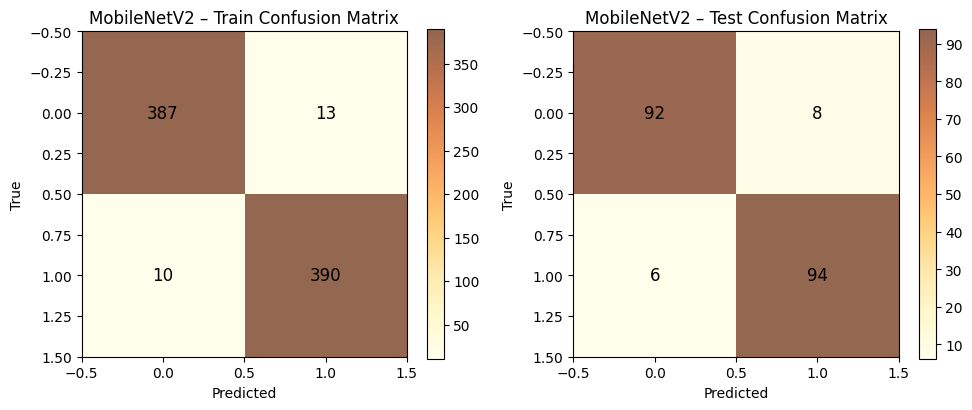

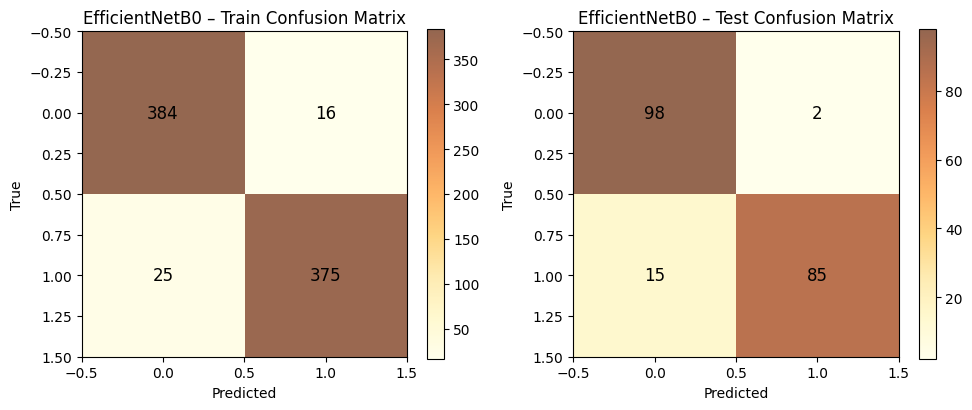

In [68]:
for model_name, data in metrics_storage.items():

    cm_train = confusion_matrix(y_train, data["ytr_pred"])
    cm_test  = confusion_matrix(y_test,  data["yte_pred"])

    plt.figure(figsize=(10,4))

    for i, (cm, title) in enumerate(
        zip([cm_train, cm_test], ["Train", "Test"])
    ):
        plt.subplot(1,2,i+1)
        plt.imshow(cm, cmap="YlOrBr", alpha=0.7)
        plt.title(f"{model_name} – {title} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.colorbar()

        # 🔹 Numbers inside matrix
        for r in range(cm.shape[0]):
            for c in range(cm.shape[1]):
                plt.text(c, r, cm[r, c],
                         ha="center", va="center",
                         color="black", fontsize=12)

    plt.tight_layout()
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.show()


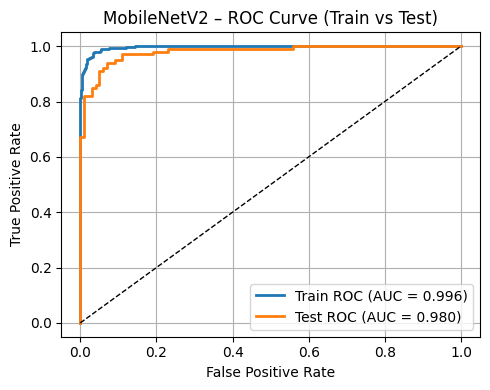

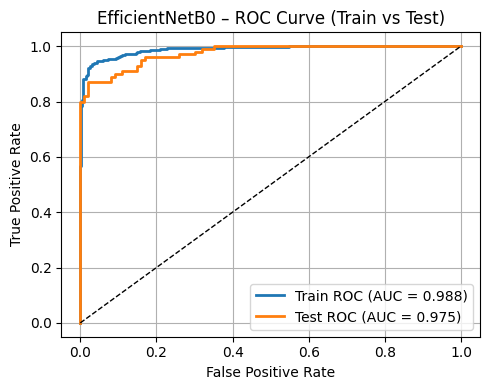

In [69]:
for model_name, data in metrics_storage.items():

    fpr_train, tpr_train, _ = roc_curve(y_train, data["ytr_prob"])
    fpr_test,  tpr_test,  _ = roc_curve(y_test,  data["yte_prob"])

    auc_train = auc(fpr_train, tpr_train)
    auc_test  = auc(fpr_test,  tpr_test)

    plt.figure(figsize=(5,4))

    plt.plot(
        fpr_train, tpr_train,
        label=f"Train ROC (AUC = {auc_train:.3f})",
        linewidth=2
    )

    plt.plot(
        fpr_test, tpr_test,
        label=f"Test ROC (AUC = {auc_test:.3f})",
        linewidth=2
    )

    plt.plot([0,1], [0,1], 'k--', linewidth=1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} – ROC Curve (Train vs Test)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{model_name}_roc_curve.png")
    plt.show()


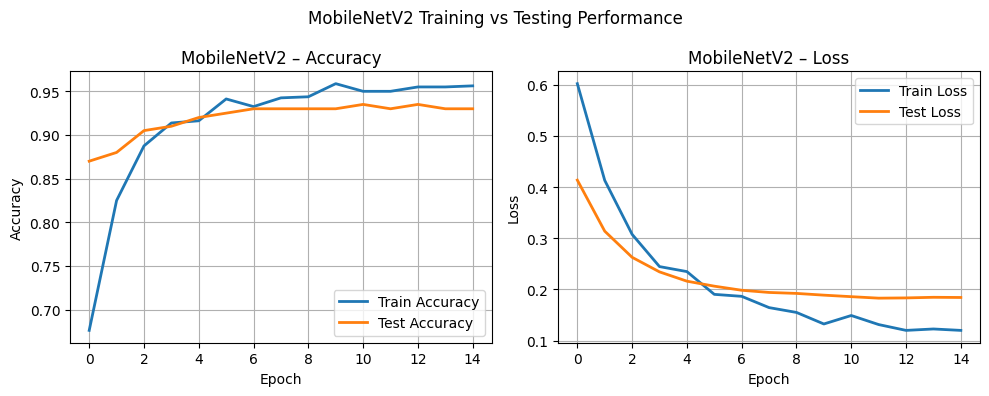

In [70]:
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_m.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_m.history['val_accuracy'], label='Test Accuracy', linewidth=2)
plt.title('MobileNetV2 – Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history_m.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_m.history['val_loss'], label='Test Loss', linewidth=2)
plt.title('MobileNetV2 – Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('MobileNetV2 Training vs Testing Performance')
plt.tight_layout()
plt.savefig("mobilenet_performance.png")
plt.show()


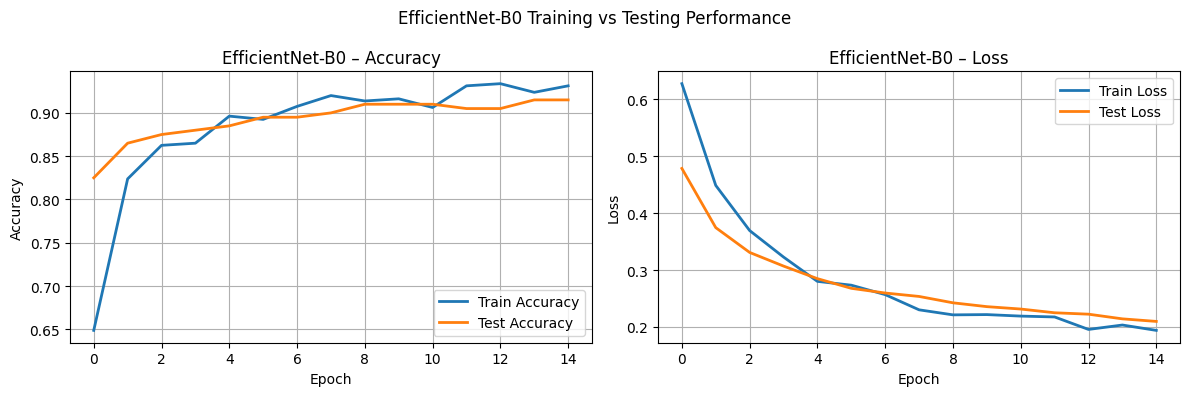

In [71]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_e.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history_e.history['val_accuracy'], label='Test Accuracy', linewidth=2)
plt.title('EfficientNet-B0 – Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history_e.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history_e.history['val_loss'], label='Test Loss', linewidth=2)
plt.title('EfficientNet-B0 – Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle('EfficientNet-B0 Training vs Testing Performance')
plt.tight_layout()
plt.savefig("efficientnet_performance.png")
plt.show()


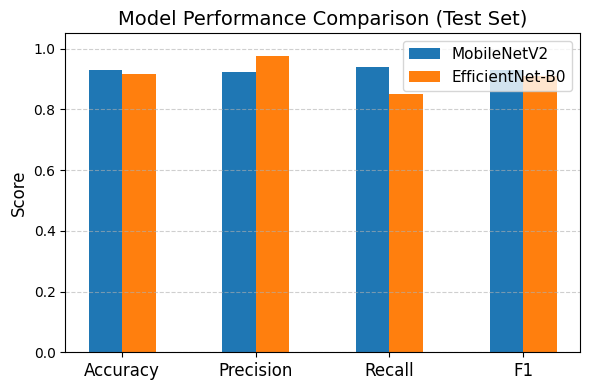

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Filter TEST results only
df_test = df_results[df_results["Dataset"] == "Test"]

metrics = ["Accuracy", "Precision", "Recall", "F1"]
models = df_test["Model"].values

x = np.arange(len(metrics))
width = 0.25

plt.figure(figsize=(6,4))

# Bars for each model
plt.bar(
    x - width/2,
    df_test.loc[df_test["Model"] == "MobileNetV2", metrics].values.flatten(),
    width,
    label="MobileNetV2",
    color="#1f77b4"   # Blue
)

plt.bar(
    x + width/2,
    df_test.loc[df_test["Model"] == "EfficientNetB0", metrics].values.flatten(),
    width,
    label="EfficientNet-B0",
    color="#ff7f0e"   # Orange
)

plt.xticks(x, metrics, fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.05)
plt.title("Model Performance Comparison (Test Set)", fontsize=14)
plt.legend(fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.savefig("model_performance_comparison.png")
plt.show()
